# 1. Introduction
>Just one more kernel with CNN in this competition :)
To work with large data, use ImageDataGenerator.flow_from_dataframe as input for model.
First, import necessary libraries:

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import time
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
PRETRAINED_DIR = "../input/pretrained-model/"
OUTPUT_DIR ="./model/"
#INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
#PRETRAINED_DIR = "../pretrained/"
#OUTPUT_DIR = "./model/"


TRAIN_DATA_DIR = INPUT_DIR + 'train_images'
#TRAIN_DATA_DIR = INPUT_DIR + 'img_sz_512'


IMSIZES = (224, 240, 260, 300, 380, 456, 528, 600)

NUM_CLASSES = 12
IMAGE_SIZE= (224,224)  #(256,256)

BATCH_SIZE = 32 #32  16
TRAIN_BATCH_SIZE = 1024 #512 256
#16，512 works

print(os.listdir(OUTPUT_DIR))
print(os.listdir(INPUT_DIR))

toy=False

all_df = pd.read_csv(INPUT_DIR + "train.csv")
if toy:
    all_df = all_df.sample(5000)


NB_TRAIN = all_df.shape[0]  #15930 #4275 #32706
NB_VALID = NB_TRAIN * 0.1 #1770 #475 #10902

print(all_df.shape)
all_df.head()

['best_DenseNet121.h5', 'best_EfficientNetB7.h5', 'best_XceptionDenseNet121-v1.h5', 'best_XceptionDenseNet121.h5', 'best_XceptionDenseNet121_1.h5', 'best_XceptionDenseNet121_2.h5', 'best_XceptionDenseNet121_3.h5', 'plant_model.hdf5']
['img_sz_256', 'img_sz_384', 'img_sz_512', 'img_sz_640', 'sample_submission.csv', 'submission-v2.csv', 'test_images', 'test_images1', 'train.csv', 'train_images']
(18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


# 2. Exploratory Data Analysis
>Check labels balancing
Check whether labels are balanced

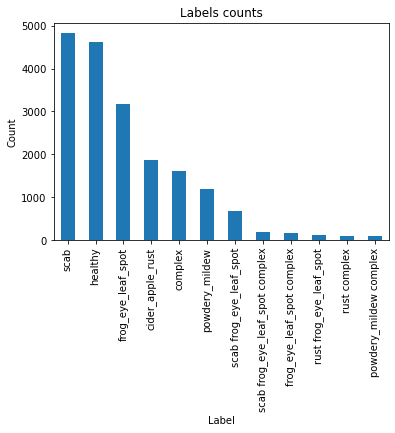

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
cider_apple_rust                   1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64


In [7]:
all_df.labels.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print(all_df.labels.value_counts())

In [8]:
all_df.isnull().any()

image     False
labels    False
dtype: bool

ValueError: a must be greater than 0 unless no samples are taken

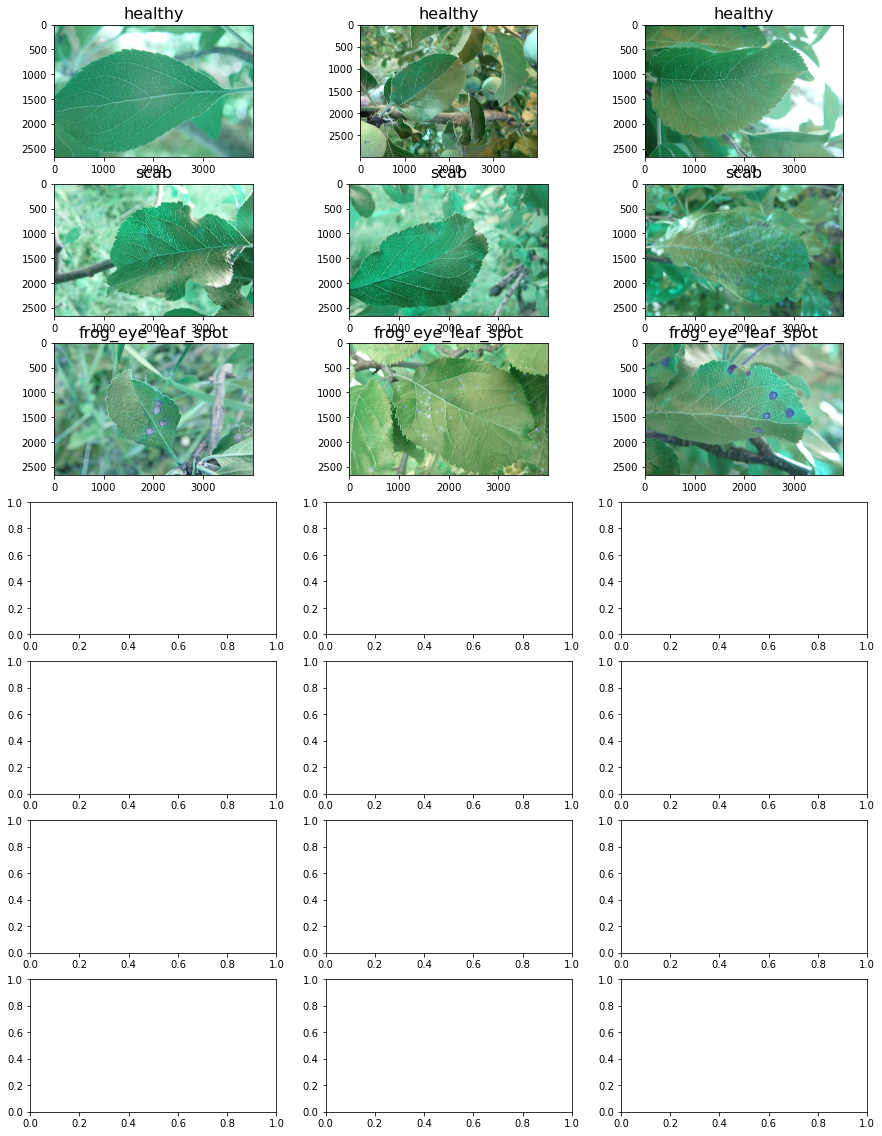

In [9]:
class ImageViewer:
    def read_img(self,id, folder='train_images'):
        """
        Read image by it's id
        """
        file=INPUT_DIR + folder + '/' + str(id)
        #print(file)
        im=cv2.imread(file)
        #print(im)
        return im

    def draw_sample_images(self):
        """
        Draw disease and healthy images for EDA
        """
        ncols=3
        f, ax = plt.subplots(nrows=7,ncols=ncols, 
                             figsize=(5*ncols,5*4))
        i=-1
        #cider_apple_rust removed
        captions=['healthy','scab','frog_eye_leaf_spot','rust','complex','powdery_mildew','scab frog_eye_leaf_spot']
        # Draw one row for scab, one row for healthy images
        for label in captions:
            i=i+1
            group = all_df[all_df['labels']==label]
            samples = group['image'].sample(ncols).values
            #print(samples)
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                #print(im)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()
    
ImageViewer().draw_sample_images()

# 3. Data preparation
>Here we are going to balance dataset and prepare image generator

## Train and test split

In [ ]:
class DataPreparation:
    """
    Train/test
    """
    def train_test_split(self, all_df):
        """
        Balanced split to train, test and val
        """
        # Split to train and test before balancing
        train_df, test_df = train_test_split(all_df, random_state=24, test_size=0.05, shuffle=False)
        print(train_df.shape)
#         # Split train to train and validation datasets
#         train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=24)
        # Number of samples in each category
        
        #ncat_bal = train_df['labels'].value_counts().max()
#        #ncat_bal = int(len(train_df)/train_df['label'].cat.categories.size)
        #train_df = train_df.groupby('labels', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        #print(train_df.shape, ncat_bal)
        return train_df, test_df
    
    def plot_balanced(self, train_df, all_df):
        """
        Plot samples per category before and after balancing
        """
        f, axs = plt.subplots(1,2,figsize=(15,4))
        # Before balancing
        all_df.labels.value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('Label')
        axs[0].set_ylabel('Count')
        # After balancing
        train_df.labels.value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels after balancing')
        axs[1].set_xlabel('Label')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()


# Train/test/validation split with balanced labels in train
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(all_df)

# Plot before and after balancing
data_prep.plot_balanced(train_df, all_df)
print(all_df.shape,train_df.shape, test_df.shape)

## Create image generator
>Keras ImageDataGenerator can work with dataframe of file names. Our train, validation and test dataframes contain file name in id column and ImageDataGenerator can understand id.

In [ ]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size= BATCH_SIZE #16 #1024 #32 #8
        self.img_size= IMAGE_SIZE #(256,256)#(512,512)#(192,128) #(96,64) (384,256)  #(4000,2672)

        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.1,
            #featurewise_center=False,
            #featurewise_std_normalization=False,
            fill_mode='nearest',
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10, #180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.15, # Randomly zoom image 
            width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True  # randomly flip images
            )
 
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df, #all_df, #
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,#test_df ,#
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        
        
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col='labels',
            #has_ext=False,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')

        
        
        
# Create generators   
#(43608, 2) (4658, 2)
generators = Generators(train_df, test_df)
print("Generators created")

In [ ]:
print(generators.train_generator.class_indices)
class_labels = generators.train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
print(class_labels)
classes = list(class_labels.values())
print(classes)        
#print(len(self.generator.classes))

#y_pred = []
#for item in self.y_pred:
#    y_pred.append(label_batch)
def get_class(one_hot):
    for i in range(NUM_CLASSES):
        if one_hot[i] == 1:
            return classes[i]
    
            
            
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 2
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1, columns*rows):
    
    img_batch, label_batch = generators.train_generator.next()
    fig.add_subplot(rows, columns, i)
    
    plt.title(get_class(label_batch[i]))  
    plt.imshow(img_batch[i])
    plt.axis('off')
plt.show()

# 4. Create and train the model
>Put all creation and training code in one class. Will experiment with model architecture later.

In [ ]:
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        #(18632, 2) (17700, 2) (932, 2)
        #15930 , 1770, 932
        
        self.nb_train_samples = NB_TRAIN  #15930 #4275 #32706
        self.nb_validation_samples = NB_VALID #1770 #475 #10902
        self.batch_size =  TRAIN_BATCH_SIZE #512 #512 #32 #1024   #32
               
        
        self.generators = generators
        self.img_width = IMAGE_SIZE[0]
        self.img_height = IMAGE_SIZE[1]
        print(self.img_width,self.img_height)
        
    
    def create_model(self, model_name):
        #will preload and consume lots memory
        #dict_model = {
        #    "Xception": self.create_model_1(),
        #    "DenseNet121": self.create_model_2(),
        #    "XceptionDenseNet121": self.create_model_3(),
        #    "InceptionResNetV2": self.create_model_4(),
        #    "ResNet50V2": self.create_model_5(),
        #    "VGG16": self.create_model_6(),
        #    "middle": self.create_model_middle(),
        #    "small": self.create_model_small(),
        #}    
        #print("Creating "+model_name)
        if model_name == "Xception" :
                model = self.create_model_1()
        elif model_name == "EfficientNetB7": 
                model = self.create_model_0()                
        elif model_name == "DenseNet121": 
                model = self.create_model_2()
        elif model_name == "XceptionDenseNet121": 
                model = self.create_model_3()
        elif model_name == "InceptionResNetV2": 
                model = self.create_model_4()
        elif model_name == "ResNet50V2": 
                model = self.create_model_5()
        elif model_name == "VGG16": 
                model = self.create_model_6()
        elif model_name == "middle": 
                model = self.create_model_middle()
        elif model_name == "small": 
                model = self.create_model_small()
        else:
                print("Model not found")
        self.model_name = model_name
        return model
    

    def create_model_0(self):
        path0 = PRETRAINED_DIR + 'efficientnetb7_notop.h5'
        pretrained_model = tf.keras.applications.EfficientNetB7(include_top=False, weights=path0, #drop_connect_rate=0.4,
                                                                 input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='sigmoid')
        ])
        return model    
    
    #Total params: 20,886,068
    def create_model_1(self):
        path1 = PRETRAINED_DIR + 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
        pretrained_model = tf.keras.applications.xception.Xception(include_top=False, weights=path1, input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model
    
    def create_model_2(self):
        path2 = PRETRAINED_DIR + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
        pretrained_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights=path2,input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
    
        return model

    def create_model_3(self):
        path1 = PRETRAINED_DIR + 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
        xception_model = tf.keras.models.Sequential([
          tf.keras.applications.xception.Xception(include_top=False, weights=path1, input_shape=(self.img_width, self.img_height, 3)),#(512, 512, 3)),
           tf.keras.layers.GlobalAveragePooling2D(),
           tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        #xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #xception_model.summary()
        path2 = PRETRAINED_DIR + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
        densenet_model = tf.keras.models.Sequential([
        tf.keras.applications.densenet.DenseNet121(include_top=False, weights=path2,input_shape=(self.img_width, self.img_height, 3)),#(512, 512, 3)),
           tf.keras.layers.GlobalAveragePooling2D(),
           tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        #densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #densenet_model.summary()
        
        inputs = tf.keras.Input(shape=(self.img_width, self.img_height, 3)) #(512, 512, 3))

        xception_output = xception_model(inputs)
        densenet_output = densenet_model(inputs)

        outputs = tf.keras.layers.average([densenet_output, xception_output])


        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
 
    def create_model_4(self):
        pretrained_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model
    
    def create_model_5(self):
        pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
    
        return model

    #Total params: 14,720,844
    def create_model_6(self):
        pretrained_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model    
    
    def create_model_middle(self):
        model = Sequential()

        # Padding = 'same'  results in padding the input such that
        # the output has the same length as the original input
        model.add(Conv2D(32, (3, 3), padding='same',
                         input_shape= (self.img_width, self.img_height, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(12))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(NUM_CLASSES))
        model.add(Activation('softmax'))

        return model
    
    def create_model_vgg16(self):
        input_shape = (224, 224, 3)

        model = Sequential([
            Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
                   activation='relu'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(1000, activation='softmax')
        ])
        return model
    
            
    #Total params: 33,560,364    
    def create_model_small(self):
        """
        Build CNN model using img_width, img_height from fields.
        """
        model=Sequential()
        model.add(Conv2D(16, kernel_size=3, input_shape=(self.img_width, self.img_height,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
        model.add(Dropout(0.1))
        model.add(Flatten())
        model.add(Dense(64, activation = "relu"))        
        # 1 y label
        model.add(Dense(NUM_CLASSES, activation='softmax'))
        #model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

        # We use a very small learning rate 
        model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])
        return model
    
    def train(self, model, toy):
        """
        Train the model
        """
        if toy:
            epochs=10
            steps_per_epoch=10
            #steps_per_epoch = self.nb_train_samples / self.batch_size
            validation_steps=1
            #validation_steps= self.nb_validation_samples / self.batch_size
        else:
            epochs=50
            #steps_per_epoch=100
            #steps_per_epoch=30 
            
            #steps_per_epoch=20
            steps_per_epoch = self.nb_train_samples / self.batch_size
            
            #steps_per_epoch=10
            #validation_steps=5
            
            #validation_steps=100
            validation_steps= self.nb_validation_samples / self.batch_size


        # val_accuracy should be try and compare with val_loss
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', 
                            min_delta = 0, 
                            patience = 4,
                            verbose = 1,
                            restore_best_weights = True)

        #reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
        #                           verbose=1, mode='max', min_lr=0.00001)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', #'loss',
                              factor = 0.5,
                              patience = 2,
                              verbose = 1,
                              min_lr=0.000001,
                              min_delta = 0.0001)
        # Save the best model during the traning
        # loss,accuracy,val_loss,val_accuracy,lr
        check_name = OUTPUT_DIR +  'best_'+self.model_name+'.h5'
        print(check_name)
        checkpointer = ModelCheckpoint( check_name
                                        #,monitor='val_loss'
                                        #,mode="min"
                                        ,monitor='val_accuracy'
                                        ,mode="max"                                       
                                        ,verbose=1
                                        ,save_best_only=True)
                                        #,save_weights_only=True)

        #callbacks = [ checkpointer,lr_callback]        
            
        callbacks = [earlystopper, checkpointer, lr_callback] #reduce_lr]
        # Train
        training = model.fit_generator(self.generators.train_generator
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=callbacks
                                ,use_multiprocessing=False
                                ,shuffle=True
                                ,verbose=True)     
        
        # Get the best saved weights
        model.load_weights(check_name)
        return training

In [ ]:
#model = trainer.create_model_3()  # Best ! 0.9219 Total params: 27,935,872  
#model = trainer.create_model_2()   # good ! 0.8750 Total params: 7,049,804  
#model = trainer.create_model_small() # worse 0.5625 Total params: 33,560,364
#model = trainer.create_model()  # bad delete; Total params: 33,682,380
#model = trainer.create_model("middle") # bad Total params: 3,017,928

#model = trainer.create_model("VGG16") # 0.7344  Total params: 14,720,844
#model = trainer.create_model("ResNet50V2") # 0.8906 Total params: 23,589,388
#model = trainer.create_model("InceptionResNetV2") # 0.8906 Total params: Total params: 54,355,180

#model = trainer.create_model("XceptionDenseNet121") # 0.9062 Total params: 27,935,872

# Create and train the model
trainer = ModelTrainer(generators)
model = trainer.create_model("EfficientNetB7") 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
start = time.time()
training=trainer.train(model, toy)
print("Trained Time : ", time.time() - start)

# training is a time consuming job, pls use this file for training only, use notebook-submit-only link as below for submission 
# the prevois output files( checkpoint weights) will be deleted when training, pls download and save at local, or upload to our private dataset "pretrained-model"

# the best checkpoint should be 
# 1. download first, 
# 2. upload to pretrained-model dataset
# 3. load in file below
# https://www.kaggle.com/rebootshen/notebook-submit-only/edit

# 5. Evaluate trained model
Also put all evaluation code into one class for better code modularity.

In [ ]:
# Saving model history ： causing trouble for submission.csv!!
#pd.DataFrame(training.history).to_csv('ModelHistory.csv')

In [ ]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator
        # predict the data
        steps=5
        self.y_pred_raw = model.predict(self.generator, steps=steps)
        
        self.y_pred = np.argmax(self.y_pred_raw, axis=1)
        self.y_true=y_true[:len(self.y_pred)]
        #print(self.y_pred_raw[0])
        #print(self.y_pred)
        #print(len(self.y_pred))
        #print(self.y_true[0], y_true[0])
        #print(y_true.shape, self.y_true.shape)
        #print(y_true)
        #print(y_true[:len(self.y_pred)] )
    
    def plot_history(self): 
        fig, ax1 = plt.subplots(figsize=(15, 8))
        history = self.training

        ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
        ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
        ax1.grid(True)
        ax1.set_xlabel('iteration')
        ax1.legend(loc="best", fontsize=9)    
        ax1.set_ylabel('loss', color='r')
        ax1.tick_params('y', colors='r')

        accname = "accuracy"
        if accname in history.history:
            ax2 = ax1.twinx()

            ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
            ax2.plot(history.history['val_' + accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_' + accname][-1]))

            ax2.legend(loc="best", fontsize=12)
            ax2.set_ylabel('acc', color='b')        
            ax2.tick_params('y', colors='b')
        
    """
    Accuracy, evaluation
    """
    def plot_history1(self):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,5))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['accuracy'], label="Accuracy")
        ax[1].plot(self.training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    
    def plot_roc(self):
        #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        #print(self.y_true.shape, self.y_pred.shape)
        #print(self.y_true[0], self.y_pred[0])
        #print(self.generator.classes)
        #print(metrics.classification_report(self.y_true, self.y_pred))
        
        class_labels = self.generator.class_indices
        print(class_labels)
        class_labels = {v: k for k, v in class_labels.items()}
        classes = list(class_labels.values())
        #print(classes)        
        #print(len(self.generator.classes))
        
        y_pred = []
        for item in self.y_pred:
            y_pred.append(classes[item])
            
        
        self.y_pred = y_pred 
        print(metrics.classification_report(self.y_true, self.y_pred))
        

        
        #print('Confusion Matrix')
        #print(confusion_matrix(validation_generator.classes, y_pred))
        #print('Classification Report')
        #target_names = list(class_labels.values())
        #print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Create evaluator instance
#evaluator = Evaluator(model, training, generators.test_generator, test_df.labels.values)

# Draw accuracy and loss charts
#evaluator.plot_history()

# ROC curve
#evaluator.plot_roc()

# Classification report
#evaluator.print_report()

# 5. Submission
>Use ImageDataGenerator to reduce memory usage. My initial idea was to use generator.flow_from_directory for input/test folder but it didn't work for me. Quick fix is to use generator.flow_from_dataframe on dataframe with list of filenames.

In [ ]:
class Submitter:
    """
    Predict and submit
    """
    def __init__(self, model, img_size):
        self.model = model
        batch_size=BATCH_SIZE
        print("Initializing submitter")
        #Submission generator
        # flow_from_directory for input/test didn't work for me, so quick fix is to use flow_from_dataframe with list of files
        # Load list of files from test folder into dataframe
        self.test_files_df=pd.DataFrame()
        TEST_DIR = INPUT_DIR + 'test_images/'
        self.test_files_df['image']=os.listdir(TEST_DIR)
        print("Loaded test files list")
        
        
        # Create generator in it
        #self.generator=ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.generator = _test_datagen.flow_from_dataframe(
                    dataframe=self.test_files_df,
                    directory=TEST_DIR,
                    x_col="image",
                    y_col=None,
                    #has_ext=True,
                    class_mode=None,
                    batch_size=batch_size,
                    seed=42,
                    shuffle=False,
                    target_size=img_size)    
        
        print('Submission generator created')    


    def predict_for_submit(self):
        """
        Predict submission test data and form dataframe to submit
        """
        print("Forming submission dataframe...")
        # Predict
        y_pred = self.model.predict(self.generator)
        y_pred = np.argmax(y_pred, axis=1)
        print(y_pred)
        
        
        y_pred_str = []
        for item in y_pred:
            y_pred_str.append(classes[item])
        
        self.test_files_df['labels'] = y_pred_str
        # Write to csv
        self.test_files_df.to_csv('./submission.csv', index=False)
        print("Submission completed: written submission.csv")
        return self.test_files_df

In [ ]:
if not toy:
    # Get dataframe for submission
    submitter = Submitter(model, IMAGE_SIZE)
    submission_df = submitter.predict_for_submit()     
    submission_df.head()
else:
    submission_df = pd.DataFrame()
    print("Do not submit in toy mode")

In [ ]:
df_sizes = pd.DataFrame({'Data type':['Train', 'Test', 'Submission'], 
                      'Row count':[len(train_df.values), len(test_df.values), len(submission_df.values)]})

sns.barplot(x='Data type', y='Row count', data=df_sizes)
plt.title('Rows in data')
plt.show()